In [10]:
from datasets.get_datasets import *
from revision import *
from boostsrl import boostsrl
import random

## Parameters

In [11]:
target = 'advisedby'
test_size = 0.3
small_train_size = 0.3
validation_size = 0.2
revision_threshold = 0.8
max_revision_iterations = 10

## Dataset

Sameproject, sameperson and samecourse predicates are not being used.

In [12]:
[facts, pos, neg] = get_uwcse_dataset(target, acceptedPredicates=[
'professor',
'student',
'advisedby',
'tempadvisedby',
'ta',
'hasposition',
'publication',
'inphase',
'courselevel',
'yearsinprogram',
'projectmember',
])

## Background  configuration

In [13]:
bk = boostsrl.example_data('background')
bk = ['professor(+person).',
'student(+person).',
'advisedby(+person,+person).',
'advisedby(+person,-person).',
'advisedby(-person,+person).',
'tempadvisedby(+person,+person).',
'tempadvisedby(+person,-person).',
'tempadvisedby(-person,+person).',
'ta(+course,+person,+quarter).',
'ta(-course,+person,+quarter).',
'ta(+course,-person,+quarter).',
'ta(+course,+person,-quarter).',
'ta(-course,+person,-quarter).',
'ta(+course,-person,-quarter).',
'hasposition(+person,+faculty).',
'hasposition(+person,-faculty).',
'hasposition(-person,+faculty).',
'publication(+title,+person).',
'publication(+title,-person).',
'publication(-title,+person).',
'inphase(+person,+prequals).',
'inphase(+person,-prequals).',
'inphase(-person,+prequals).',
'courselevel(+course,+level).',
'courselevel(+course,-level).',
'courselevel(-course,+level).',
'yearsinprogram(+person,+year).',
'yearsinprogram(-person,+year).',
'yearsinprogram(+person,-year).',
'projectmember(+project,+person).',
'projectmember(+project,-person).',
'projectmember(-project,+person).']
#'sameproject(project, project).',
#'samecourse(course, course).',
#'sameperson(person, person).',]

background = boostsrl.modes(bk, [target], useStdLogicVariables=False, treeDepth=8, nodeSize=3, numOfClauses=8)

## Sampling examples

In [14]:
# shuffle all examples
random.shuffle(pos)
random.shuffle(neg)

# separate train and test
test_pos = pos[:int(test_size*len(pos))]
test_neg = neg[:int(test_size*len(neg))]
train_pos = pos[int(test_size*len(pos)):]
train_neg = neg[int(test_size*len(neg)):]

# learn from scratch in a small dataset
s_train_pos = train_pos[:int(small_train_size*len(train_pos))]
s_train_neg = train_neg[:int(small_train_size*len(train_neg))]

# shuffle all train examples
random.shuffle(train_pos)
random.shuffle(train_neg)

# train set used in revision and validation set
r_train_pos = train_pos[int(validation_size*len(train_pos)):]
r_train_neg = train_neg[int(validation_size*len(train_neg)):]
validation_pos = train_pos[:int(validation_size*len(train_pos))]
validation_neg = train_neg[:int(validation_size*len(train_neg))]

print('Total examples')
print('Positive examples: %s' % len(pos))
print('Negative examples: %s' % len(neg))
print('\n')
print('Train and test sets from total')
print('Train Positive examples: %s' % len(train_pos))
print('Train Negative examples: %s' % len(train_neg))
print('Test Positive examples: %s' % len(test_pos))
print('Test Negative examples: %s' % len(test_neg))
print('\n')
print('Small dataset')
print('Train Positive examples: %s' % len(s_train_pos))
print('Train Negative examples: %s' % len(s_train_neg))
print('\n')
print('Revision theory train dataset and validation')
print('Train Positive examples: %s' % len(r_train_pos))
print('Train Negative examples: %s' % len(r_train_neg))
print('Validation Positive examples: %s' % len(validation_pos))
print('Validation Negative examples: %s' % len(validation_neg))

Total examples
Positive examples: 113
Negative examples: 4079


Train and test sets from total
Train Positive examples: 80
Train Negative examples: 2856
Test Positive examples: 33
Test Negative examples: 1223


Small dataset
Train Positive examples: 24
Train Negative examples: 856


Revision theory train dataset and validation
Train Positive examples: 64
Train Negative examples: 2285
Validation Positive examples: 16
Validation Negative examples: 571


## Learning from small dataset

WILL-Produced Tree:
% FOR advisedby(A, B):
%   if ( professor(B), student(A) )
%   then if ( publication(C, A) )
%   | then if ( publication(C, B) )
%   | | then return 0.8581489350995123;  // std dev = 0,000, 6,000 (wgt'ed) examples reached here.  /* #pos=6 */
%   | | else if ( ta(D, A, E) )
%   | | | then return 0.4581489350995122;  // std dev = 1,095, 5,000 (wgt'ed) examples reached here.  /* #neg=2 #pos=3 */
%   | | | else if ( tempadvisedby(F, B), publication(C, G), ta(H, G, I) )
%   | | | | then return 0.5248156017661788;  // std dev = 0,816, 3,000 (wgt'ed) examples reached here.  /* #neg=1 #pos=2 */
%   | | | | else return 0.024815601766178873;  // std dev = 0,913, 6,000 (wgt'ed) examples reached here.  /* #neg=5 #pos=1 */
%   | else if ( tempadvisedby(J, B), publication(K, J) )
%   | | then return 0.19148226843284552;  // std dev = 0,816, 3,000 (wgt'ed) examples reached here.  /* #neg=2 #pos=1 */
%   | | else if ( tempadvisedby(L, B), ta(M, A, N) )
%   | | | then return 0.52481

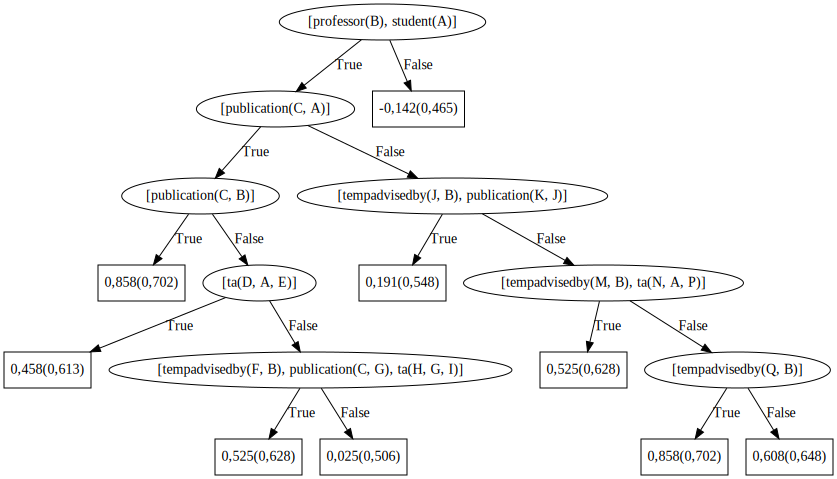

In [15]:
delete_model_files()
model = boostsrl.train(background, s_train_pos, s_train_neg, facts)
learning_time = model.traintime()
will = model.get_will_produced_tree()
structured = model.get_structured_tree().copy()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)

## Learning from complete dataset

WILL-Produced Tree:
% FOR advisedby(A, B):
%   if ( professor(B), student(A) )
%   then if ( publication(C, B), publication(C, A) )
%   | then return 0.8258908705833826;  // std dev = 0,177, 31,000 (wgt'ed) examples reached here.  /* #neg=1 #pos=30 */
%   | else if ( publication(D, A), publication(D, E), tempadvisedby(F, E) )
%   | | then if ( publication(D, F) )
%   | | | then return 0.5248156017661788;  // std dev = 0,816, 3,000 (wgt'ed) examples reached here.  /* #neg=1 #pos=2 */
%   | | | else if ( tempadvisedby(G, B) )
%   | | | | then return -0.1418510649004878;  // std dev = 0,000, 9,000 (wgt'ed) examples reached here.  /* #neg=9 */
%   | | | | else return 0.10814893509951218;  // std dev = 0,433, 8,000 (wgt'ed) examples reached here.  /* #neg=6 #pos=2 */
%   | | else if ( ta(H, A, I) )
%   | | | then return 0.7510060779566546;  // std dev = 0,309, 28,000 (wgt'ed) examples reached here.  /* #neg=3 #pos=25 */
%   | | | else if ( tempadvisedby(J, B), publication(K, A) )
%   | | | 

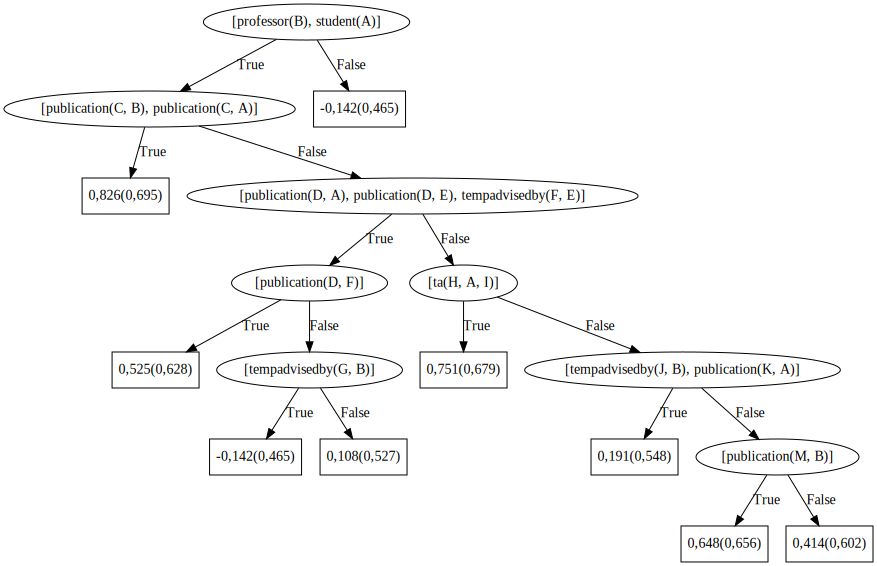

In [16]:
delete_model_files()
model = boostsrl.train(background, train_pos, train_neg, facts)
learning_time = model.traintime()
will = model.get_will_produced_tree()
#structured = model.get_structured_tree().copy()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)

## Theory Revision

Performing parameter learning
******************************************
WILL-Produced Tree:
% FOR advisedby(A, B):
%   if ( professor(B), student(A) )
%   then if ( publication(C, A) )
%   | then if ( publication(C, B) )
%   | | then return 0.8105298874804645;  // std dev = 0,976, 21,000 (wgt'ed) examples reached here.  /* #neg=1 #pos=20 */
%   | | else if ( ta(D, A, E) )
%   | | | then return 0.13087620782678497;  // std dev = 1,477, 11,000 (wgt'ed) examples reached here.  /* #neg=8 #pos=3 */
%   | | | else if ( tempadvisedby(F, B), publication(C, G), ta(H, G, I) )
%   | | | | then return 0.5248156017661788;  // std dev = 0,816, 3,000 (wgt'ed) examples reached here.  /* #neg=1 #pos=2 */
%   | | | | else return 0.8581489350995121;  // std dev = 2,11e-08, 3,000 (wgt'ed) examples reached here.  /* #pos=3 */
%   | else if ( tempadvisedby(J, B), publication(K, J) )
%   | | then return 0.23314893509951226;  // std dev = 1,369, 8,000 (wgt'ed) examples reached here.  /* #neg=5 #pos=3 */
%   

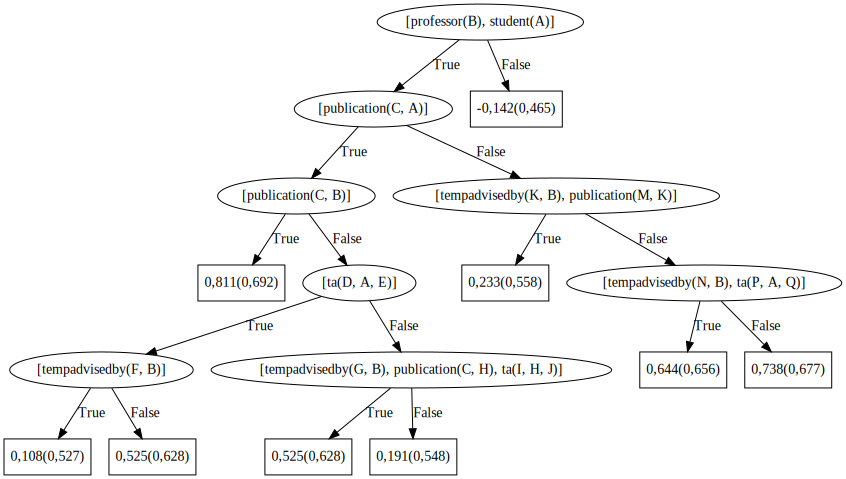

In [17]:
total_revision_time = 0
best_aucroc = 0
best_structured = None

print('Performing parameter learning')
print('******************************************')
delete_model_files()
model = boostsrl.train(background, r_train_pos, r_train_neg, facts, refine=get_refine_file(structured))
learning_time = model.traintime()
will = model.get_will_produced_tree()
structured = model.get_structured_tree().copy()
results = boostsrl.test(model, validation_pos, validation_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
total_revision_time += learning_time + inference_time
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total learning time: %s seconds' % learning_time)
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
#print('Tree:')
#model.tree(0, target, image=True)

best_aucroc = t_results['AUC ROC']
best_structured = structured.copy()
save_model_files()

for i in range(max_revision_iterations):
    print('Refining iteration %s' % str(i+1))
    print('******************************************')
    found_better = False
    for candidate in get_cantidates(best_structured, revision_threshold):
        print('Refining node candidate')
        print('******************************************')
        delete_model_files()
        model = boostsrl.train(background, r_train_pos, r_train_neg, facts, refine=candidate)
        learning_time = model.traintime()
        will = model.get_will_produced_tree()
        results = boostsrl.test(model, validation_pos, validation_neg, facts)
        inference_time = results.testtime()
        t_results = results.summarize_results()
        total_revision_time += learning_time + inference_time
        print('WILL-Produced Tree:')
        print_will_produced_tree(will)
        print('\n')
        print('Results:')
        print(t_results)
        print('\n')
        print('Total learning time: %s seconds' % learning_time)
        print('Total inference time: %s seconds' % inference_time)
        print('AUC ROC: %s' % t_results['AUC ROC'])
        print('\n')
        #print('Tree:')
        #model.tree(0, target, image=True)
        print('******************************************')

        if t_results['AUC ROC'] > best_aucroc:
            found_better = True
            best_aucroc = t_results['AUC ROC']
            best_structured = model.get_structured_tree().copy()
            save_model_files()
    print('Best Tree AUC ROC so far: %s' % best_aucroc)
    print('******************************************\n')
    if found_better == False:
        break

print('******************************************')
delete_model_files()
get_saved_model_files()
delete_test_files()
print('Total revision time: %s' % total_revision_time)
print('Best validation AUC ROC: %s' % best_aucroc)
will = model.get_will_produced_tree()
results = boostsrl.test(model, test_pos, test_neg, facts)
inference_time = results.testtime()
t_results = results.summarize_results()
print('WILL-Produced Tree:')
print_will_produced_tree(will)
print('\n')
print('Results:')
print(t_results)
print('\n')
print('Total inference time: %s seconds' % inference_time)
print('AUC ROC: %s' % t_results['AUC ROC'])
print('\n')
print('Tree:')
model.tree(0, target, image=True)